## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images
* Sample Check
* Read Images and Prepare Objectpoint Array

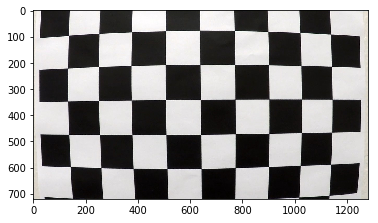

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
%matplotlib inline

# Show Image example
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

In [2]:
# Detect Chessboard Corners
def detect_corners(nx, ny, images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, : 2] = np.mgrid[0 : nx, 0 : ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for img in images:
        # Converrt to Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints


# Undistort Image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist


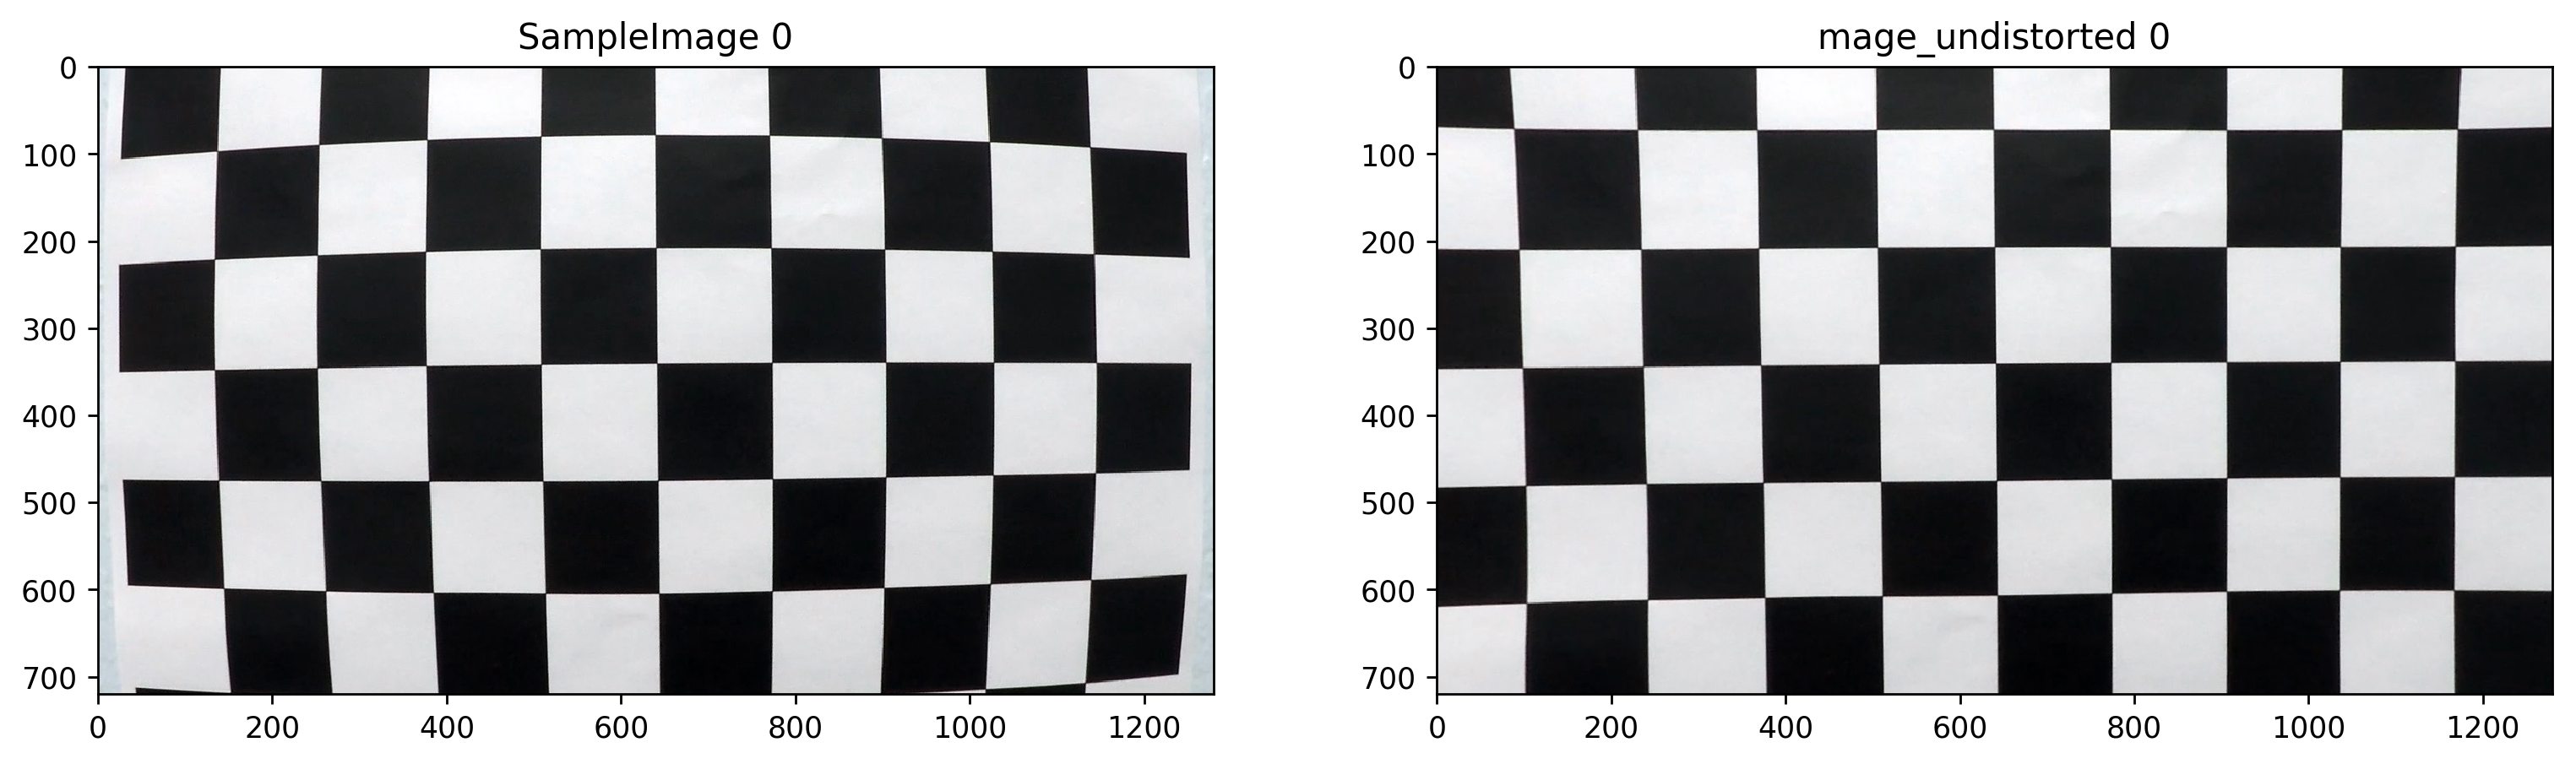

In [3]:
# Define the number of corners
nx = 9
ny = 6

# Prepare Images
imagefiles = glob.glob('./camera_cal/calibration*.jpg')
images = []
for fname in imagefiles:
    img = cv2.imread(fname)
    images.append(img)

objpoints, imgpoints = detect_corners(nx, ny, images)

# Select Sample
index = random.randint(0, len(images) - 1)
img = images[index]
undistorted = cal_undistort(img, objpoints, imgpoints)


plt.figure(figsize=(15,7), dpi=250)
plt.subplot(1,2, 1)
plt.title('SampleImage ' + str(index)) 
plt.imshow(img)

# Show Undistorted
plt.subplot(1,2, 2)
plt.title('mage_undistorted ' + str(index)) 
plt.imshow(undistorted)
plt.savefig('./output_images/undistort_output.png')

In [4]:
# Calculate Perspective Transform Matrix & Inverse Matrix for Chessboard 
img_size = (img.shape[1], img.shape[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    undistorted = cal_undistort(img, objpoints, imgpoints)
    offset = 100
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    # Show Warped
    plt.figure(figsize=(15,7), dpi=250)
    plt.subplot(1,2, 1)
    plt.imshow(img)
    plt.title('original')
    plt.subplot(1,2, 2)
    plt.title('Image_warped' + str(index)) 
    plt.imshow(warped)

src = [[  585.           455.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           455.        ]]
dst = [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


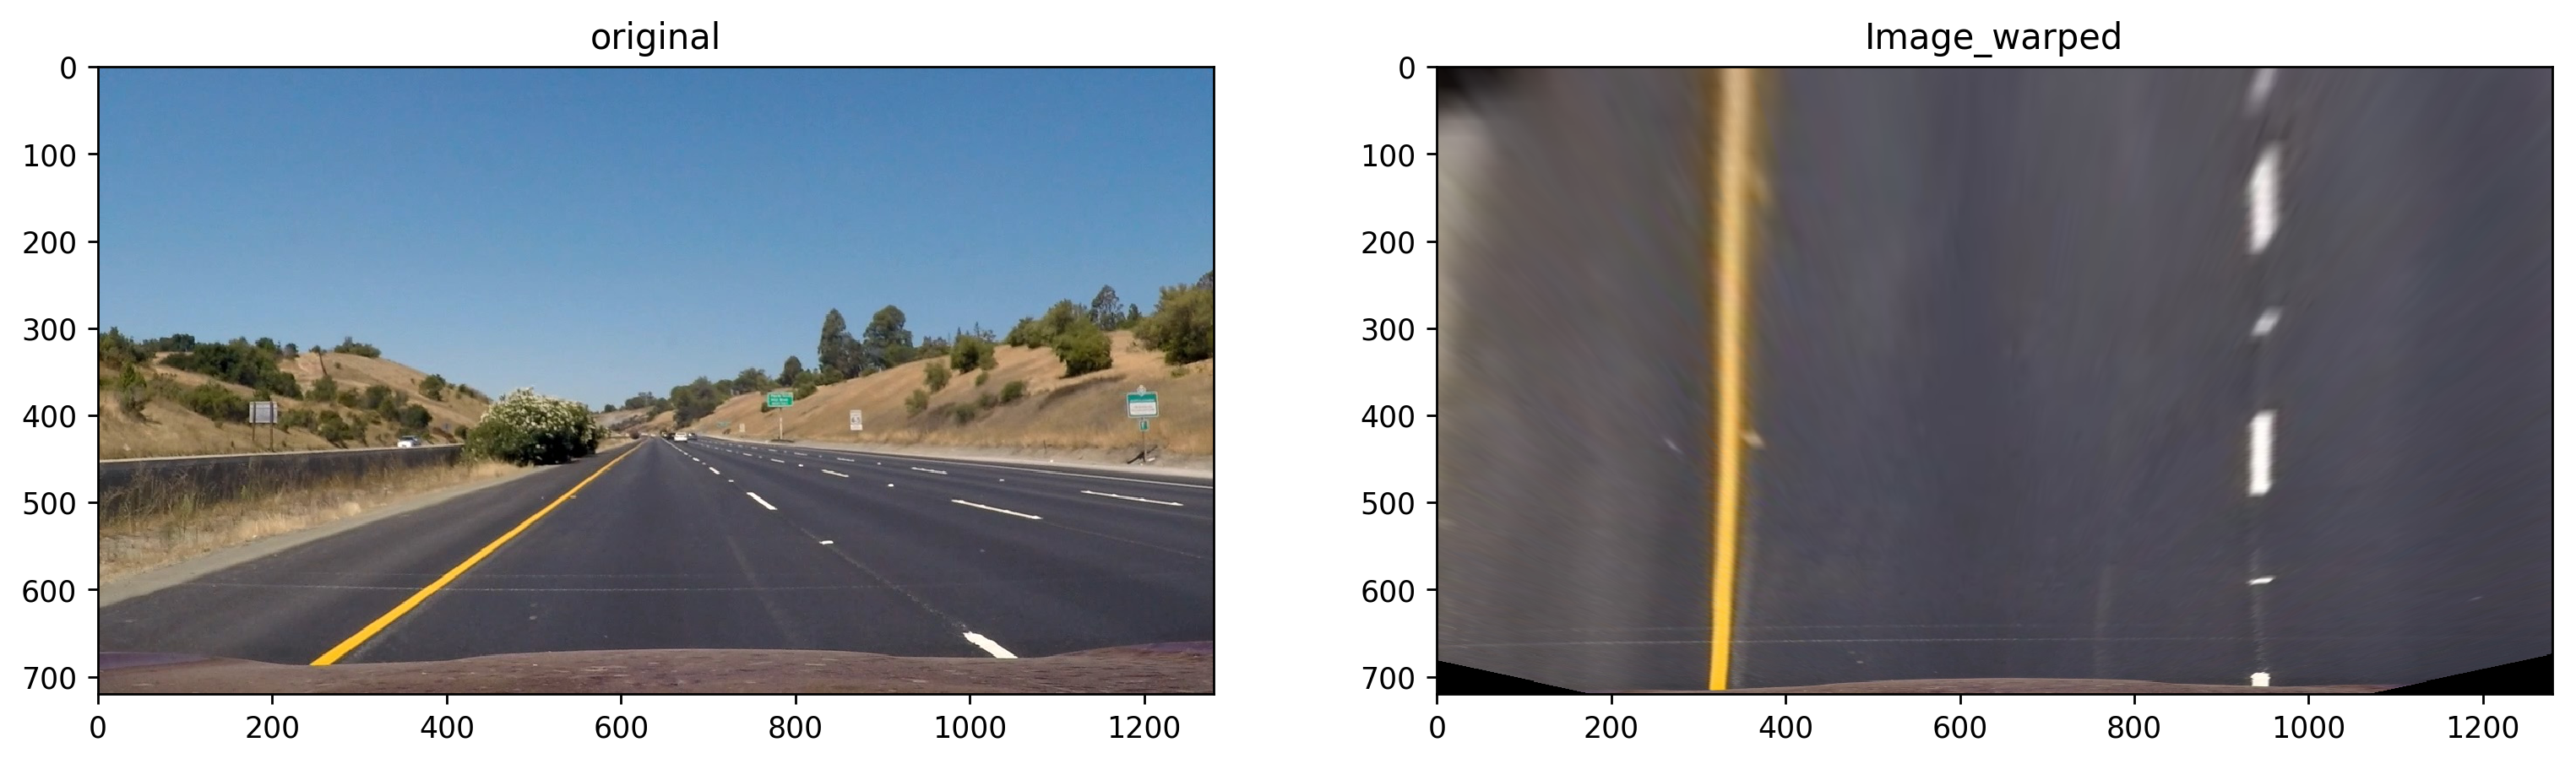

In [5]:
# Define the source point and destination point for perspective transform
offset = 100    
src = np.float32(
[[(img_size[0] / 2) - 55, img_size[1] / 2 + 95],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 95]])
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])
# Calculate Perspective Transform Matrix & Inverse Matrix for Chessboard 
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
 
print('src = ' + str(src))
print('dst = ' + str(dst))

    
# Prepare Images
def warper(img, nx, ny):
    img_size = (img.shape[1], img.shape[0])
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

# Check by test image
imagefiles = glob.glob('./test_images/*.jpg')
images = []
for fname in imagefiles:
    img = mpimg.imread(fname)
    images.append(img)

# Select Sample
index = random.randint(0, len(images) - 1)
img = images[index]

warped = warper(img, nx, ny)

if warped.any():
    # Show Warped
    plt.figure(figsize=(15,7), dpi=250)
    plt.subplot(1,2, 1)
    plt.imshow(img)
    plt.title('original')
    plt.subplot(1,2, 2)
    plt.title('Image_warped') 
    plt.imshow(warped)
    plt.savefig('./output_images/warped_straight_lines.jpg')

## Next, Thresholding

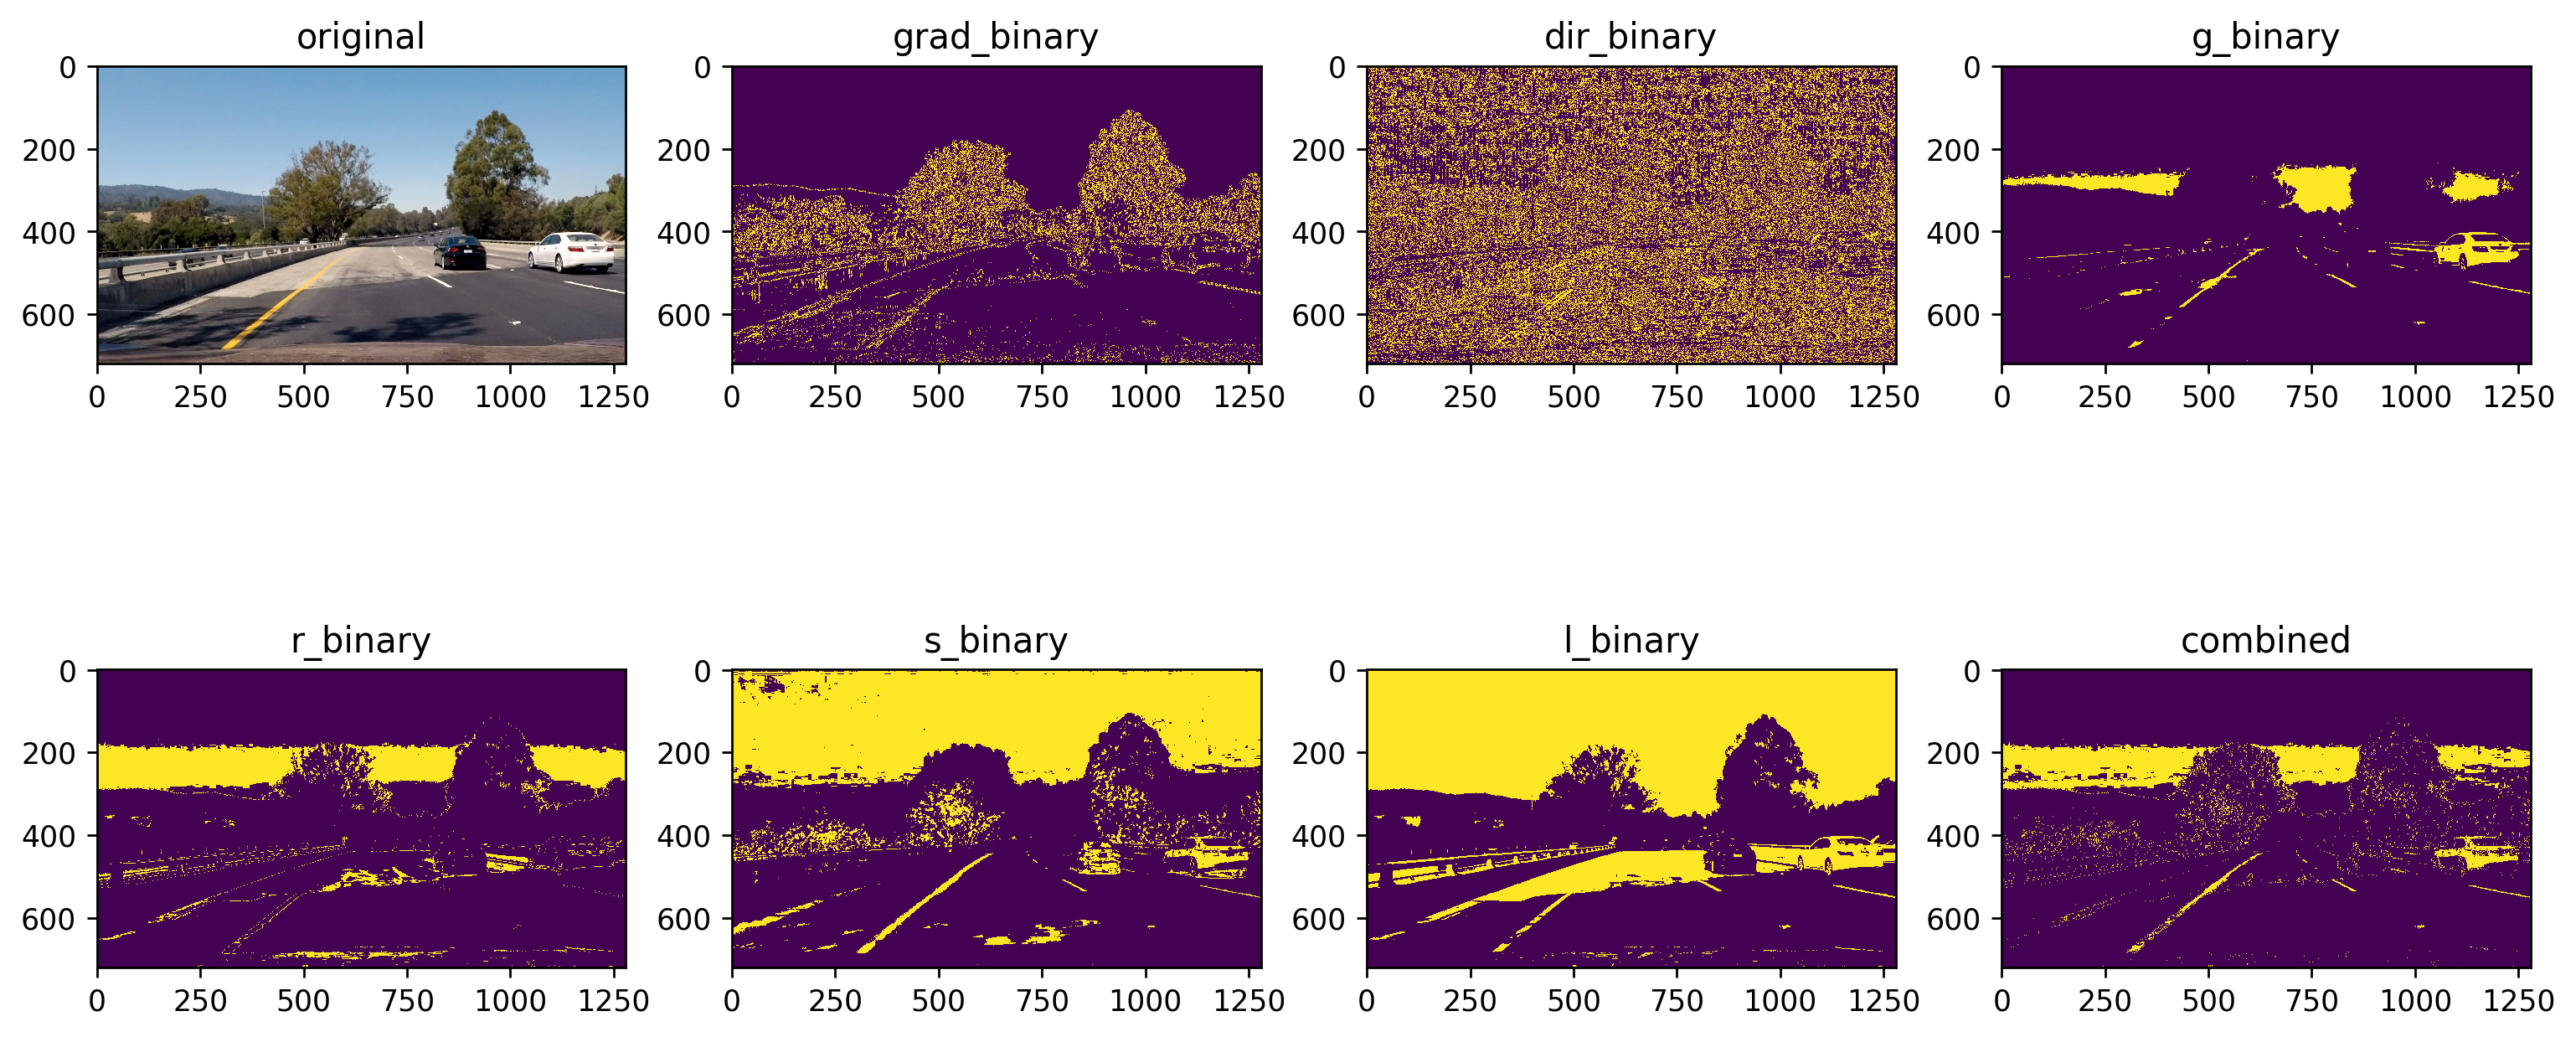

In [178]:
# Sobel threshhold (x-orient)
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Direction of gradient threshold
def dir_threshold(gray, sobel_kernel=15, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# Color thresholds by S-channel of HLS
def s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Color thresholds by l-channel of HLS
def l_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

# Color thresholds by H-channel of HLS
def h_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

# Color thresholds by R-channel of RGB
def r_select(img, thresh=(0, 255)):
    r_channel = img[:,:,0]
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary_output

# Color thresholds by R-channel of RGB
def g_select(img, thresh=(0, 255)):
    g_channel = img[:,:,1]
    binary_output = np.zeros_like(g_channel)
    binary_output[(g_channel > thresh[0]) & (g_channel <= thresh[1])] = 1
    return binary_output
    
# Sample Image
img =  mpimg.imread('./test_images/test4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Run the function
grad_binary = abs_sobel_thresh(gray, orient='x', thresh_min=10, thresh_max=30)
dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=(0.7, 1.3))
s_binary = s_select(img, thresh=(110, 255))
l_binary = l_select(img, thresh=(140, 255))
r_binary = r_select(img, thresh=(150, 180))
g_binary = g_select(img, thresh=(200, 255))
tmp = np.zeros_like(g_binary)
# Combined threshold
combined = np.zeros_like(dir_binary)
combined[(grad_binary + s_binary + g_binary + r_binary) > 1] = 1

# Show Sample Image & Threshold
plt.figure(figsize=(15,7), dpi=250)
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title('original')
plt.subplot(2, 4, 2)
plt.imshow(grad_binary)
plt.title('grad_binary')
plt.subplot(2, 4, 3)
plt.title('dir_binary')
plt.imshow(dir_binary)
plt.subplot(2, 4, 4)
plt.title('g_binary')
plt.imshow(g_binary)
plt.subplot(2, 4, 5)
plt.title('r_binary')
plt.imshow(r_binary)
plt.subplot(2, 4, 6)
plt.title('s_binary')
plt.imshow(s_binary)
plt.subplot(2, 4, 7)
plt.title('l_binary')
plt.imshow(l_binary)
plt.subplot(2, 4, 8)
plt.title('combined')
plt.imshow(combined)
plt.savefig('./output_images/binary_combo_example.jpg')

## Perspective Transform

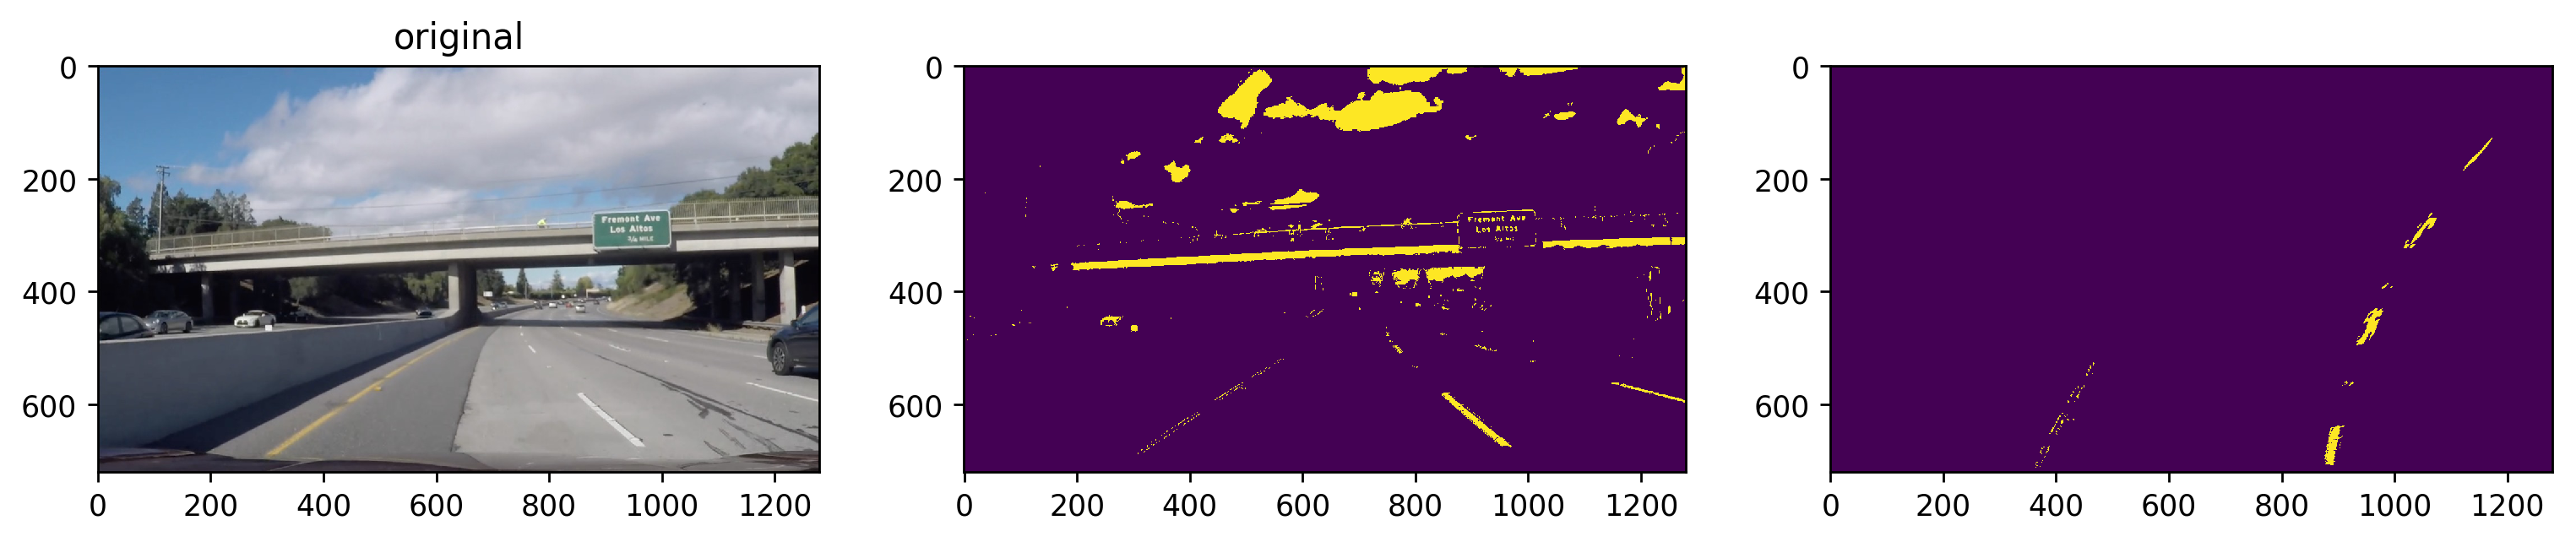

In [179]:
def thresh_pipeline(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grad_binary = abs_sobel_thresh(gray, orient='x', thresh_min=10, thresh_max=30)
    s_binary = s_select(img, thresh=(110, 255))
    g_binary = g_select(img, thresh=(200, 255))
    r_binary = r_select(img, thresh=(170, 255))
    # Combined threshold
    combined = np.zeros_like(s_binary)
    combined[(grad_binary + s_binary + g_binary + r_binary) > 1] = 1

    return combined
    
result = thresh_pipeline(img)

# Sample Image
img =  mpimg.imread('./test_images/test9.jpg')
# Run the function
combined = thresh_pipeline(img)
warped = warper(combined, nx, ny)


# Show Sample Image & Threshold
plt.figure(figsize=(15,7), dpi=250)
plt.subplot(1,3, 1)
plt.imshow(img)
plt.title('original')
plt.subplot(1,3, 2)
plt.imshow(combined)
plt.subplot(1,3, 3)
plt.imshow(warped)

In [180]:
def measure_curvature(lefty, leftx, righty, rightx):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img.shape[0]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


curvature =482.480674419 m


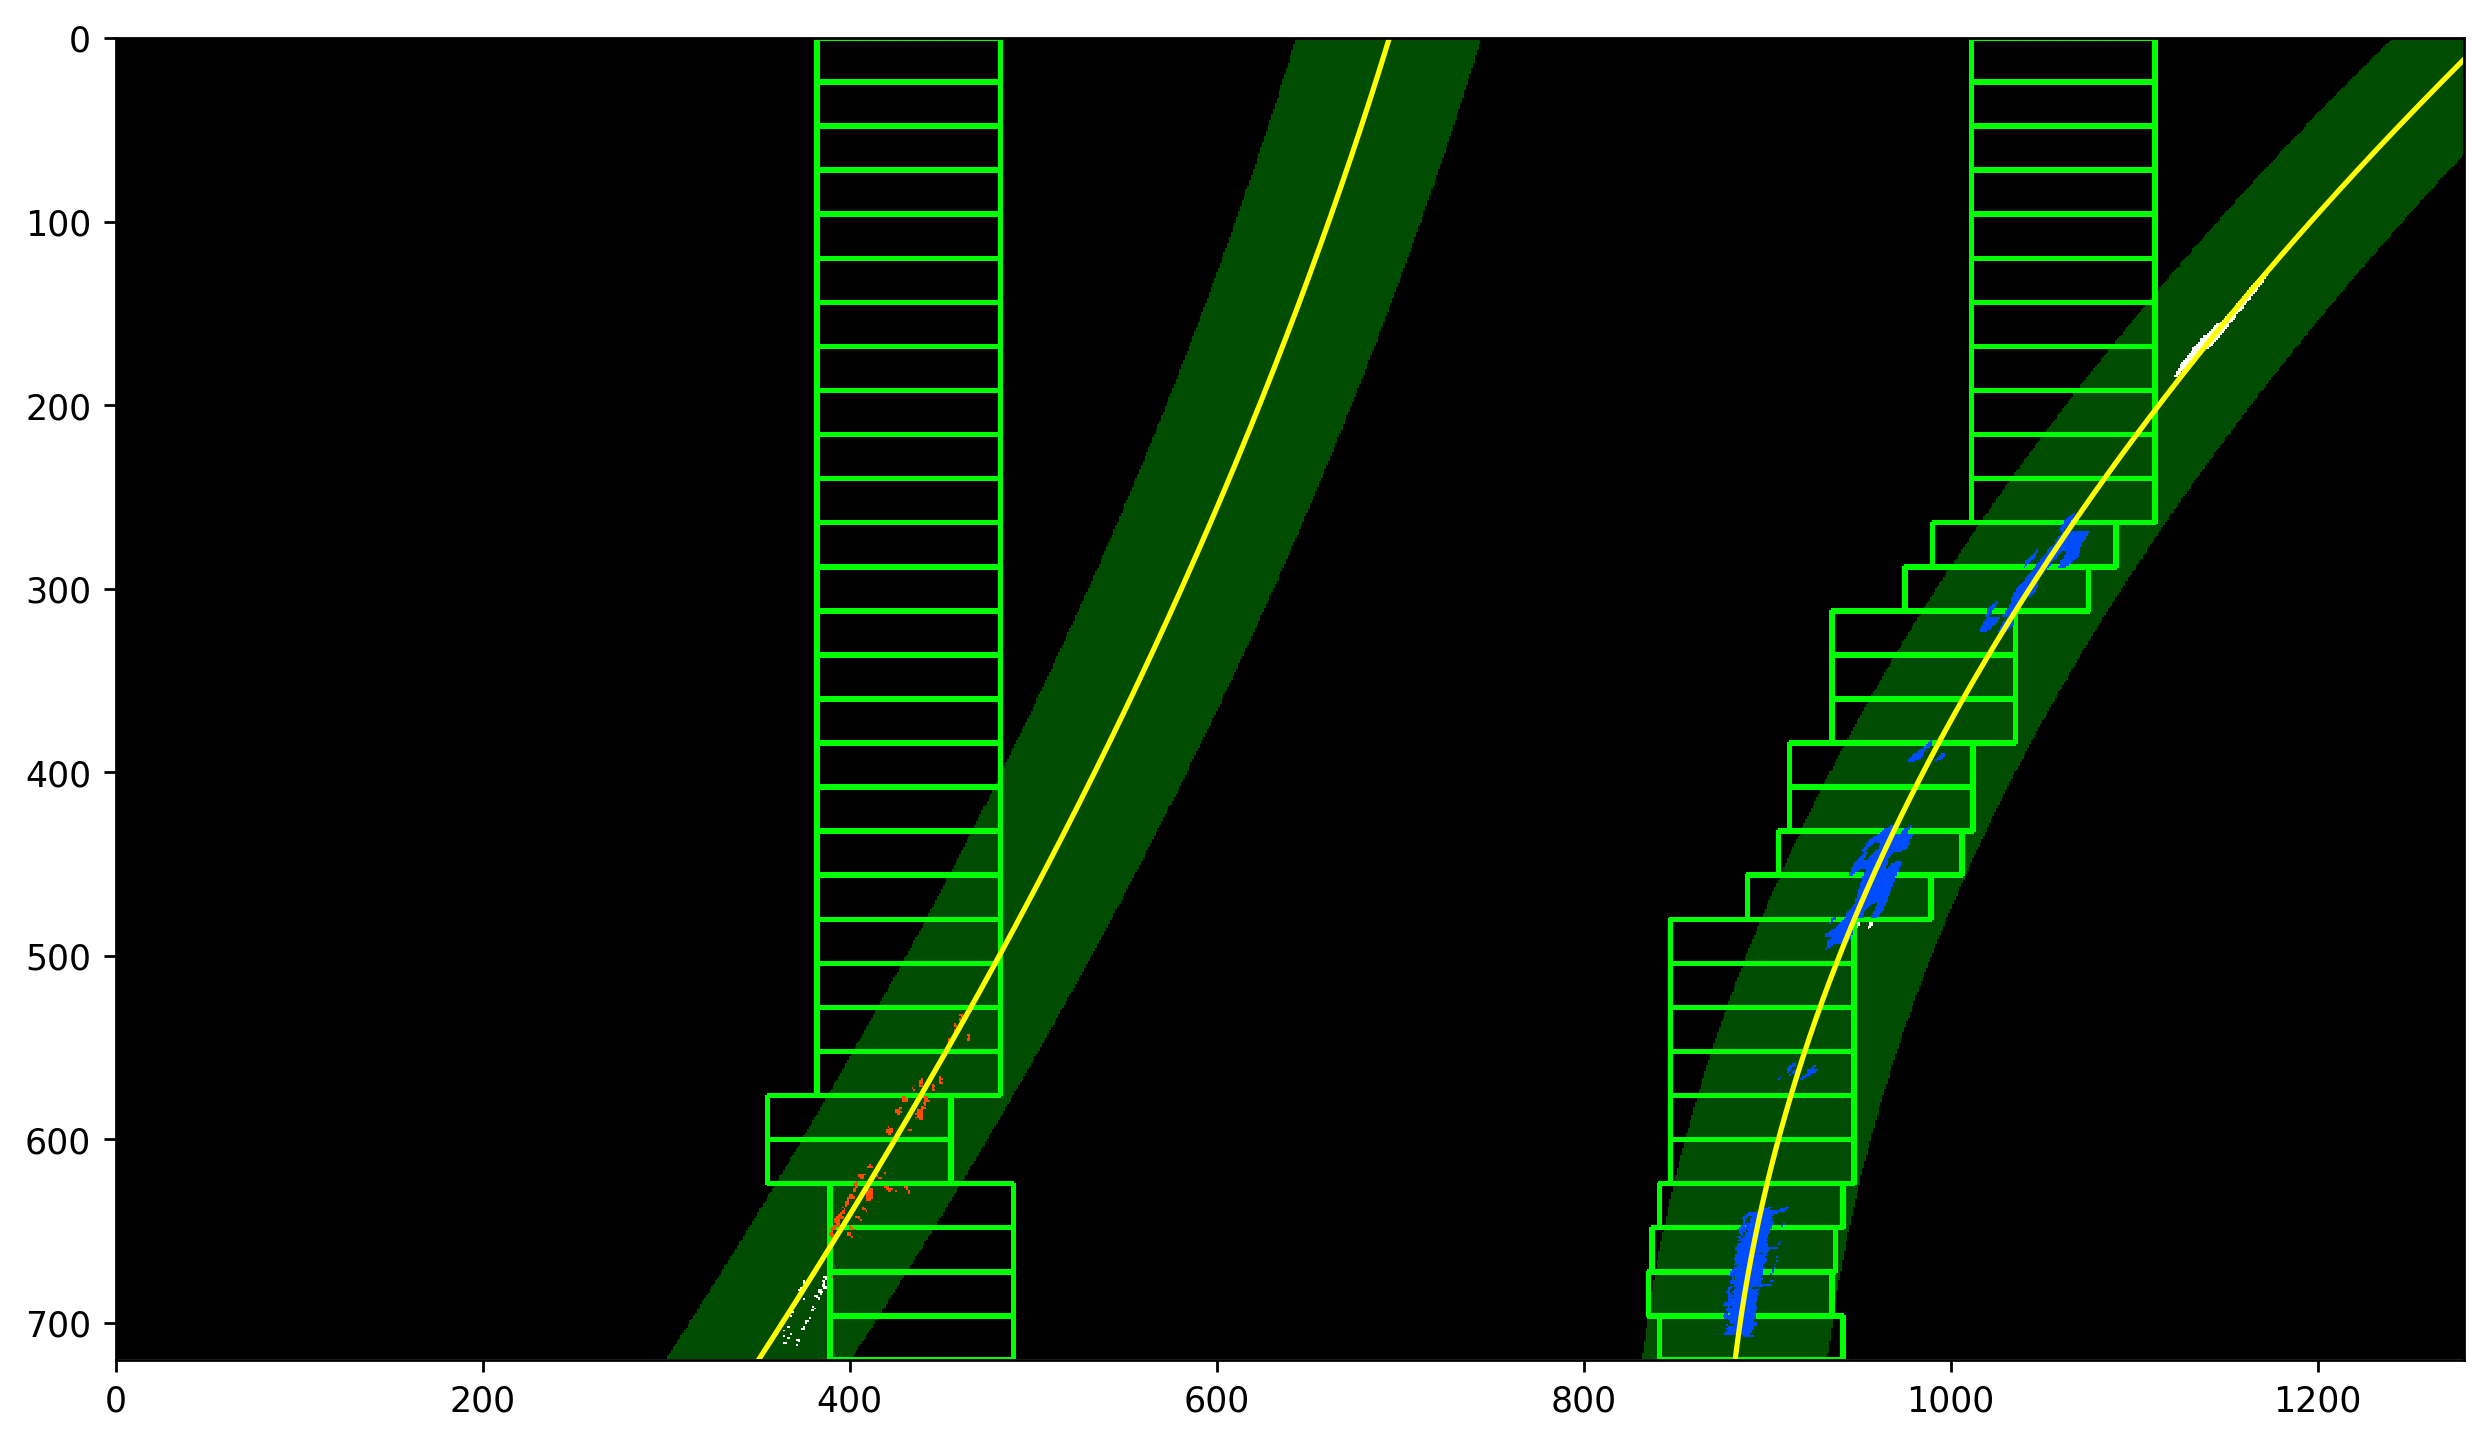

In [181]:
def detect_lane_line(binary_warped):
    bottom_half = np.int(binary_warped.shape[0]/2)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[bottom_half:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = 255*np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows =30

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    if left_lane_inds.any() and right_lane_inds.any(): 
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        # Create an image to draw on and an image to show the selection window
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        test_img = np.copy(out_img)
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        lane = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        left_curvature, right_curvature = measure_curvature(lefty, leftx, righty, rightx)

    else:
        lane = binary_warped
        left_fit = None
        right_fit = None
        left_curvature = None
        right_curvature = None

    return lane, left_fit, right_fit, left_curvature, right_curvature

lane, left_fit, right_fit, left_curvature, right_curvature = detect_lane_line(warped)
ploty = np.linspace(0, lane.shape[0]-1, lane.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
curvature = (left_curvature + right_curvature) / 2

print('curvature =' + str(curvature) + ' m')
plt.figure(figsize=(15,7), dpi=250)
plt.imshow(lane)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('./output_images/color_fit_lines.jpg')

In [182]:
# For look ahead filter
def simple_detect_lane_line(binary_warped, left_fit, right_fit):
    # Create an output image to draw on and  visualize the result
    out_img = 255*np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8')
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    
    if left_lane_inds.any() and right_lane_inds.any(): 
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        test_img = np.copy(out_img)
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        lane = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        left_curvature, right_curvature = measure_curvature(lefty, leftx, righty, rightx)

    else:
        lane = binary_warped
        left_fit = None
        right_fit = None
        left_curvature = None
        right_curvature = None
            
    return lane, left_fit, right_fit, left_curvature, right_curvature



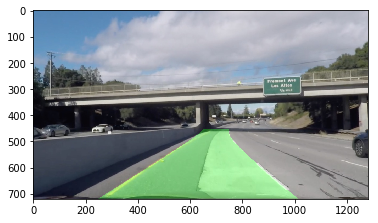

In [183]:
def on_the_original(img, binary_warped, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Fit a second order polynomial to pixel positions in each fake lane line
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    if result is None:
        result = img

    return result

result = on_the_original(img, combined, left_fit, right_fit)

plt.imshow(result)

## Video

In [184]:
# Define a class to receive the characteristics of each line detection        
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #count the iteration
        self.count = 0
        #for Debug
        self.total_count = 0

In [185]:
def reset(line):
        # was the line detected in the last iteration?
        line.detected = False  
        # x values of the last n fits of the line
        line.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        line.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        line.best_fit = []
        #polynomial coefficients for the most recent fit
        line.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        line.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        line.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        line.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        line.allx = None  
        #y values for detected line pixels
        line.ally = None
        #count the iteration
        line.count = 0

In [194]:
def check_detection_result(line, img):
    sanity_check = True
    distance_check = np.mean(np.absolute(line.allx[1] - line.allx[0]))
    curvature_check = np.max(line.allx[1]-line.allx[0]) * np.min(line.allx[1] - line.allx[0])
    # Detect two lines are too wide or narrow
    if distance_check < 200 or distance_check > 1000:
        print('distance_check = ' + str(distance_check))
        sanity_check = False
        line.total_count += 1
    # Detect tow lines are parallel, not cross
    if curvature_check < 0:
        print('curvature_check')
        sanity_check = False        
    return sanity_check

In [195]:
line = Line()
def video_pipeline(img):
    
    combined = thresh_pipeline(img)
    warped = warper(combined, nx, ny)
    # First frame when start / after reset
    if line.count == 0:
        lane, left_fit, right_fit, left_curvature, right_curvature = detect_lane_line(warped)
    # Next Frame after start / reset
    else:
        lane, left_fit, right_fit, left_curvature, right_curvature = simple_detect_lane_line(warped, line.current_fit[0], line.current_fit[1])

    # Check Detection Result 
    if left_fit is not None and right_fit is not None:
        line.detected = True
       # Fit a second order polynomial to pixel positions in each fake lane line
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        line.current_fit = [left_fit, right_fit] 
        line.radius_of_curvature = [left_curvature, right_curvature]
        line.line_base_pos = (img_size[0]/2- (right_fitx[img_size[1]-1] - left_fitx[img_size[1]-1]))*3.7/700
        line.allx = [left_fitx, right_fitx]  
        line.ally = [ploty, ploty]

        # Sanity Check
        sanity_check = check_detection_result(line, img)
        if sanity_check:
            # Set parameters in Line object
            line.recent_xfitted.append([left_fitx, right_fitx])
            line.bestx = np.mean(line.recent_xfitted, axis=0)
            line.best_fit.append(line.current_fit)
            curvature = (left_curvature+right_curvature)/2
            line.count += 1
            result = on_the_original(img, warped, line.current_fit[0], line.current_fit[1])
        else:
            if line.count >1:
                best_fit = np.mean(line.best_fit, axis=0)
                result = on_the_original(img, warped, best_fit[0], best_fit[1])
                curvature = (left_curvature+right_curvature)/2
                # take old one
                line.count -=1
                line.best_fit.pop(0)
            else:
                line.detected = False
                curvature = np.mean(line.radius_of_curvature)
                reset(line)
                result = img
        # 20 times iteration
        if line.count == 20:
            # take old one
            line.best_fit.pop(0)
            line.count -= 1
    # when it fails, ouput original image 
    else:
        line.detected = False
        reset(line)
        curvature = None
        result = img
    # put text of curvature and vehicle offset on the screen
    if curvature is not None and line.line_base_pos is not None:
        text1 = 'Radius of Curvature = ' + str(np.int(curvature))
        text2 = 'Vehicle is ' + str(np.round(line.line_base_pos, 2)) + 'm left of center'
        cv2.putText(result, text1, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, 4)
        cv2.putText(result, text2, (50, 85), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, 4)
    return result

In [198]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './output_images/project_video_result.mp4'
clip1 = VideoFileClip('./project_video.mp4')

white_clip = clip1.fl_image(video_pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video ./output_images/project_video_result.mp4
[MoviePy] Writing video ./output_images/project_video_result.mp4



 12%|█▏        | 152/1261 [00:26<02:51,  6.46it/s]


 24%|██▍       | 303/1261 [00:49<02:28,  6.43it/s]


 36%|███▌      | 454/1261 [01:14<03:21,  4.01it/s]


 48%|████▊     | 605/1261 [01:38<01:45,  6.24it/s]


 60%|█████▉    | 756/1261 [02:02<01:23,  6.05it/s]


 72%|███████▏  | 907/1261 [02:27<01:00,  5.88it/s]


 84%|████████▍ | 1057/1261 [02:54<00:34,  5.97it/s]


 96%|█████████▌| 1205/1261 [03:20<00:09,  5.96it/s]


100%|█████████▉| 1260/1261 [03:29<00:00,  5.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_result.mp4 

CPU times: user 3min 47s, sys: 31.8 s, total: 4min 19s
Wall time: 3min 30s
